# Project 5: NLP on Financial Statements

In [1]:
import nltk
import numpy as np
import pandas as pd
import pickle
import pprint
import project_helper
import project_tests
import os
import re

from tqdm import tqdm
from bs4 import BeautifulSoup
import requests
from ratelimit import limits, sleep_and_retry

### Download NLP Corpora

You'll need two corpora to run this project: the stopwords corpus for removing stopwords and wordnet for lemmatizing.

In [2]:
# nltk.download('stopwords')
# nltk.download('wordnet')

### Get 10ks

We'll be running NLP analysis on 10-k documents. To do that, we first need to download the documents. For this project, we'll download 10-ks for a few companies. To lookup documents for these companies, we'll use their CIK. If you would like to run this against other stocks, we've provided the dict additional_cik for more stocks. However, the more stocks you try, the long it will take to run.

In [3]:
cik_lookup = {
    'AMZN': '0001018724',
    'AMD': '0000002488',
    'AAPL': '0000320193',
    'NVIDIA': '0001045810',
    'ORCL': '0001341439',
    'BMY': '0000014272',
    'CNP': '0001130310',
    'CVX': '0000093410',
    'FL': '0000850209',
    'FRT': '0000034903',
    'HON': '0000773840'
}

additional_cik = {
    'AEP': '0000004904',
    'AXP': '0000004962',
    'BA': '0000012927',
    'BK': '0001390777',
    'CAT': '0000018230',
    'DE': '0000315189',
    'DIS': '0001001039',
    'DTE': '0000936340',
    'ED': '0001047862',
    'EMR': '0000032604',
    'ETN': '0001551182',
    'GE': '0000040545',
    'IBM': '0000051143',
    'IP': '0000051434',
    'JNJ': '0000200406',
    'KO': '0000021344',
    'LLY': '0000059478',
    'MCD': '0000063908',
    'MO': '0000764180',
    'MRK': '0000310158',
    'MRO': '0000101778',
    'PCG': '0001004980',
    'PEP': '0000077476',
    'PFE': '0000078003',
    'PG': '0000080424',
    'PNR': '0000077360',
    'SYY': '0000096021',
    'TXN': '0000097476',
    'UTX': '0000101829',
    'WFC': '0000072971',
    'WMT': '0000104169',
    'WY': '0000106535',
    'XOM': '0000034088'}

### Get list of 10-ks

The SEC has a limit on the number of calls you can make to the website per second. In order to avoid hiding that limit, we've created the SecAPI class. This will cache data from the SEC and prevent you from going over the limit.

In [4]:
class SecAPI(object):
    SEC_CALL_LIMIT = {'calls': 10, 'seconds': 1}

    @staticmethod
    @sleep_and_retry
    # Dividing the call limit by half to avoid coming close to the limit
    @limits(calls=SEC_CALL_LIMIT['calls'] / 2, period=SEC_CALL_LIMIT['seconds'])
    def _call_sec(url):
        return requests.get(url)

    def get(self, url):
        return self._call_sec(url).text


sec_api = SecAPI()

In [5]:
def get_sec_data(cik, doc_type, start=0, count=60):
    rss_url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany' \
        '&CIK={}&type={}&start={}&count={}&owner=exclude&output=atom' \
        .format(cik, doc_type, start, count)
    sec_data = sec_api.get(rss_url)
    feed = BeautifulSoup(sec_data.encode('ascii'), 'xml').feed
    entries = [
        (
            entry.content.find('filing-href').getText(),
            entry.content.find('filing-type').getText(),
            entry.content.find('filing-date').getText())
        for entry in feed.find_all('entry', recursive=False)]

    return entries

Let's pull the list using the get_sec_data function, then display some of the results. For displaying some of the data, we'll use Amazon as an example.

In [6]:
example_ticker = 'AMZN'
sec_data = {}

for ticker, cik in cik_lookup.items():
    sec_data[ticker] = get_sec_data(cik, '10-K')

pprint.pprint(sec_data[example_ticker][:5])

[('https://www.sec.gov/Archives/edgar/data/1018724/000101872419000004/0001018724-19-000004-index.htm',
  '10-K',
  '2019-02-01'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872418000005/0001018724-18-000005-index.htm',
  '10-K',
  '2018-02-02'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872417000011/0001018724-17-000011-index.htm',
  '10-K',
  '2017-02-10'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872416000172/0001018724-16-000172-index.htm',
  '10-K',
  '2016-01-29'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872415000006/0001018724-15-000006-index.htm',
  '10-K',
  '2015-01-30')]


### Download 10-ks
As you see, this is a list of urls. These urls point to a file that contains metadata related to each filling. Since we don't care about the metadata, we'll pull the filling by replacing the url with the filling url.

In [7]:
    raw_fillings_by_ticker = {}
    for ticker, data in sec_data.items():
        raw_fillings_by_ticker[ticker] = {}
        for index_url, file_type, file_date in tqdm(data, desc='Downloading {} Fillings'.format(ticker), unit='filling'):
            if (file_type == '10-K'):
                file_url = index_url.replace('-index.htm', '.txt').replace('.txtl', '.txt')

                file_name = file_url.split("/")[-1]
                file_path = os.path.join(os.getcwd(), "data", file_name)
                file_date = file_date[2:4]
                if os.path.exists(file_path):
                    with open(file_path, 'r', encoding='utf8') as f:
                        raw_fillings_by_ticker[ticker][file_date] = f.read()
                    continue

                raw_fillings_by_ticker[ticker][file_date] = sec_api.get(file_url)
                with open(file_path, 'w+', encoding='utf8') as f:
                    f.write(raw_fillings_by_ticker[ticker][file_date])
                    f.flush()
    print('Example Document:\n\n{}...'.format(next(iter(raw_fillings_by_ticker[example_ticker].values()))[:1000]))

Example Document:

<SEC-DOCUMENT>0001018724-19-000004.txt : 20190201
<SEC-HEADER>0001018724-19-000004.hdr.sgml : 20190201
<ACCEPTANCE-DATETIME>20190131202240
ACCESSION NUMBER:		0001018724-19-000004
CONFORMED SUBMISSION TYPE:	10-K
PUBLIC DOCUMENT COUNT:		106
CONFORMED PERIOD OF REPORT:	20181231
FILED AS OF DATE:		20190201
DATE AS OF CHANGE:		20190131

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			AMAZON COM INC
		CENTRAL INDEX KEY:			0001018724
		STANDARD INDUSTRIAL CLASSIFICATION:	RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]
		IRS NUMBER:				911646860
		STATE OF INCORPORATION:			DE
		FISCAL YEAR END:			1231

	FILING VALUES:
		FORM TYPE:		10-K
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	000-22513
		FILM NUMBER:		19557427

	BUSINESS ADDRESS:	
		STREET 1:		410 TERRY AVENUE NORTH
		CITY:			SEATTLE
		STATE:			WA
		ZIP:			98109
		BUSINESS PHONE:		2062661000

	MAIL ADDRESS:	
		STREET 1:		410 TERRY AVENUE NORTH
		CITY:			SEATTLE
		STATE:			WA
		ZIP:			98109
</SEC-HEADER>
<DOCUMENT>
<TYPE>10-K
<

### Get Documents
With theses fillings downloaded, we want to break them into their associated documents. These documents are sectioned off in the fillings with the tags `<DOCUMENT>` for the start of each document and `</DOCUMENT>` for the end of each document. There's no overlap with these documents, so each `</DOCUMENT>` tag should come after the `<DOCUMENT>` with no `<DOCUMENT>` tag in between.

Implement `get_documents` to return a list of these documents from a filling. Make sure not to include the tag in the returned document text.

In [8]:
def get_documents(text):
    """
    Extract the documents from the text

    Parameters
    ----------
    text : str
        The text with the document strings inside

    Returns
    -------
    extracted_docs : list of str
        The document strings found in `text`
    """
    extracted_docs = []
    #regex for the tags
    start_pattern = re.compile(r'<DOCUMENT>')
    end_pattern = re.compile(r'</DOCUMENT>')
    
    # isolate indices of document bounds
    start_idx = [x.end() for x in re.finditer(start_pattern, text)]
    end_idx = [x.start() for x in re.finditer(end_pattern, text)]
    
    # append document body
    for doc_start, doc_end in zip(start_idx, end_idx):
        extracted_docs.append(text[doc_start:doc_end])
    return extracted_docs

In [9]:
filling_documents_by_ticker = {}

for ticker, raw_fillings in raw_fillings_by_ticker.items():
    filling_documents_by_ticker[ticker] = {}
    for file_date, filling in tqdm(raw_fillings.items(), desc='Getting Documents from {} Fillings'.format(ticker), unit='filling'):
        filling_documents_by_ticker[ticker][file_date] = get_documents(filling)


print('\n\n'.join([
    'Document {} Filed on {}:\n{}...'.format(doc_i, file_date, doc[:200])
    for file_date, docs in filling_documents_by_ticker[example_ticker].items()
    for doc_i, doc in enumerate(docs)][:3]))

Getting Documents from HON Fillings: 100%|████████████████████████████████████████| 22/22 [00:00<00:00, 69.12filling/s]


Document 0 Filed on 19:

<TYPE>10-K
<SEQUENCE>1
<FILENAME>amzn-20181231x10k.htm
<DESCRIPTION>10-K
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<html>
	<head>
	...

Document 1 Filed on 19:

<TYPE>EX-10.7
<SEQUENCE>2
<FILENAME>amzn-20181231xex107.htm
<DESCRIPTION>EXHIBIT 10.7
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<ht...

Document 2 Filed on 19:

<TYPE>EX-21.1
<SEQUENCE>3
<FILENAME>amzn-20181231xex211.htm
<DESCRIPTION>EXHIBIT 21.1
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<ht...


### Get Document Types
Now that we have all the documents, we want to find the 10-k form in this 10-k filing. Implement the `get_document_type` function to return the type of document given. The document type is located on a line with the `<TYPE>` tag. For example, a form of type "TEST" would have the line `<TYPE>TEST`. Make sure to return the type as lowercase, so this example would be returned as "test".

In [10]:
def get_document_type(doc):
    """
    Return the document type lowercased

    Parameters
    ----------
    doc : str
        The document string

    Returns
    -------
    doc_type : str
        The document type lowercased
    """
    # find next word after <TYPE> tag
    type_pattern = re.compile(r'(?<=<TYPE>)\w+[^\n]+')
    doc_type = re.search(type_pattern, doc).group(0).lower()
    
    return doc_type

With the `get_document_type` function, we'll filter out all non 10-k documents.

In [11]:
ten_ks_by_ticker = {}

for ticker, filling_documents in filling_documents_by_ticker.items():
    ten_ks_by_ticker[ticker] = []
    for file_date, documents in filling_documents.items():
        for document in documents:
            if get_document_type(document) == '10-k':
                ten_ks_by_ticker[ticker].append({
                    'cik': cik_lookup[ticker],
                    'file': document,
                    'file_date': file_date})
                
project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['cik', 'file', 'file_date'])

[
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2018123...
    file_date: '19'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2017123...
    file_date: '18'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2016123...
    file_date: '17'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2015123...
    file_date: '16'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2014123...
    file_date: '15'},
]


## Preprocess the Data
### Clean Up
As you can see, the text for the documents are very messy. To clean this up, we'll remove the html and lowercase all the text.

Before preprocess the data. Because of var takes up a lot of memory. So We need free memory first.

In [12]:
del document
del documents
del filling
del filling_documents
del filling_documents_by_ticker
del raw_fillings
del raw_fillings_by_ticker

In [13]:
def remove_html_tags(text):
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    return text


def clean_text(text):
    text = text.lower()
    text = remove_html_tags(text)
    
    return text


def cache_clean_text(ten_k, file_doc_key='file'):
    """
    因为计算多个文件的clean_text需要花费大量时间，所以计算一次后就直接当做文件存起来，下次直接使用
    :rtype: clean_text
    """
    file_name = ten_k['cik'] + '-' + ten_k['file_date'] + '-cache_clean_text.txt'
    cache_clean_text_file_path = os.path.join(os.getcwd(), "data", "cache", file_name)
    if os.path.exists(cache_clean_text_file_path):
        with open(cache_clean_text_file_path, 'r', encoding='utf8') as f:
            text = f.read()
        return text

    text = clean_text(ten_k[file_doc_key])
    with open(cache_clean_text_file_path, 'w+', encoding='utf8') as f:
        f.write(text)
        f.flush()
    return text

Using the clean_text function, we'll clean up all the documents.

In [14]:
for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Cleaning {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_clean'] = cache_clean_text(ten_k, 'file')


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_clean'])

Cleaning HON 10-Ks: 100%|███████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 610.5610-K/s]


[
  {
    file_clean: '\n10-k\n1\namzn-20181231x10k.htm\n10-k\n\n\n\n\n\...},
  {
    file_clean: '\n10-k\n1\namzn-20171231x10k.htm\n10-k\n\n\n\n\n\...},
  {
    file_clean: '\n10-k\n1\namzn-20161231x10k.htm\nform 10-k\n\n\n...},
  {
    file_clean: '\n10-k\n1\namzn-20151231x10k.htm\nform 10-k\n\n\n...},
  {
    file_clean: '\n10-k\n1\namzn-20141231x10k.htm\nform 10-k\n\n\n...},
]


### Lemmatize
With the text cleaned up, it's time to distill the verbs down. Implement the `lemmatize_words` function to lemmatize verbs in the list of words provided.

In [15]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


def lemmatize_words(words):
    """
    Lemmatize words 

    Parameters
    ----------
    words : list of str
        List of words

    Returns
    -------
    lemmatized_words : list of str
        List of lemmatized words
    """
    
    wnl = WordNetLemmatizer()
    # lemmatize verbs
    lemmatized_words = [wnl.lemmatize(w, 'v') for w in words]
    
    return lemmatized_words

In [16]:
word_pattern = re.compile('\w+')

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Lemmatize {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = lemmatize_words(word_pattern.findall(ten_k['file_clean']))


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_lemma'])

Lemmatize HON 10-Ks: 100%|███████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.1210-K/s]


[
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20181231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20171231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20161231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20151231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20141231x10k', 'htm', '...},
]


### Remove Stopwords

In [17]:
from nltk.corpus import stopwords


lemma_english_stopwords = lemmatize_words(stopwords.words('english'))

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Remove Stop Words for {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = [word for word in ten_k['file_lemma'] if word not in lemma_english_stopwords]


print('Stop Words Removed')

Remove Stop Words for HON 10-Ks: 100%|███████████████████████████████████████████████| 22/22 [00:01<00:00, 17.8410-K/s]


Stop Words Removed


## Analysis on 10ks
### Loughran McDonald Sentiment Word Lists
We'll be using the Loughran and McDonald sentiment word lists. These word lists cover the following sentiment:
- Negative 
- Positive
- Uncertainty
- Litigious
- Constraining
- Superfluous
- Modal

This will allow us to do the sentiment analysis on the 10-ks. Let's first load these word lists. We'll be looking into a few of these sentiments.

In [18]:
sentiments = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting']
sentiment_df = pd.read_csv(os.path.join(os.getcwd(), "data", "LoughranMcDonald_MasterDictionary_2018.csv"))
sentiment_df.columns = [column.lower() for column in sentiment_df.columns]

# Remove unused information
sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]

# Apply the same preprocessing to these words as the 10-k words
sentiment_df['word'] = lemmatize_words(sentiment_df['word'].str.lower())
sentiment_df = sentiment_df.drop_duplicates('word')

sentiment_df.head()

,negative,positive,uncertainty,litigious,constraining,interesting,word
9,True,False,False,False,False,False,abandon
12,True,False,False,False,False,False,abandonment
13,True,False,False,False,False,False,abandonments
51,True,False,False,False,False,False,abdicate
54,True,False,False,False,False,False,abdication


### Bag of Words
using the sentiment word lists, let's generate sentiment bag of words from the 10-k documents. Implement `get_bag_of_words` to generate a bag of words that counts the number of sentiment words in each doc. You can ignore words that are not in `sentiment_words`.

In [19]:
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer

def get_bag_of_words(sentiment_words, docs):
    """
    Generate a bag of words from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    cv = CountVectorizer(vocabulary=sentiment_words.values)
    cv_fit = cv.transform(docs)

    return cv_fit.toarray()

Using the `get_bag_of_words` function, we'll generate a bag of words for all the documents.

In [20]:
sentiment_bow_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_bow_ten_ks[ticker] = {
        sentiment: get_bag_of_words(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}


project_helper.print_ten_k_data([sentiment_bow_ten_ks[example_ticker]], sentiments)

[
  {
    negative: '[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 0 ....
    positive: '[[15  0  0 ...  0  0  0]\n [15  0  0 ...  0  0  0...
    uncertainty: '[[0 0 0 ... 1 1 2]\n [0 0 0 ... 1 1 3]\n [0 0 0 ....
    litigious: '[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 0 ....
    constraining: '[[0 0 0 ... 0 0 2]\n [0 0 0 ... 0 0 2]\n [0 0 0 ....
    interesting: '[[2 0 0 ... 0 0 0]\n [2 0 0 ... 0 0 0]\n [2 0 0 ....},
]


### Jaccard Similarity
Using the bag of words, let's calculate the jaccard similarity on the bag of words and plot it over time. Implement `get_jaccard_similarity` to return the jaccard similarities between each tick in time. Since the input, `bag_of_words_matrix`, is a bag of words for each time period in order, you just need to compute the jaccard similarities for each neighboring bag of words. Make sure to turn the bag of words into a boolean array when calculating the jaccard similarity.

求得是相近年份之间的敏感关键词的Jaccard Similarity？反应了什么？

In [21]:
from sklearn.metrics import jaccard_similarity_score

def get_jaccard_similarity(bag_of_words_matrix):
    """
    Get jaccard similarities for neighboring documents

    Parameters
    ----------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    jaccard_similarities : list of float
        Jaccard similarities for neighboring documents
    """
    jaccard_similarities = []

    bag_of_words_bool_matrix = bag_of_words_matrix.astype(bool)
    for i in range(0, bag_of_words_matrix.shape[0]-1):
        jaccard_similarities.append(jaccard_similarity_score(bag_of_words_bool_matrix[i], bag_of_words_bool_matrix[i+1]))

    return jaccard_similarities

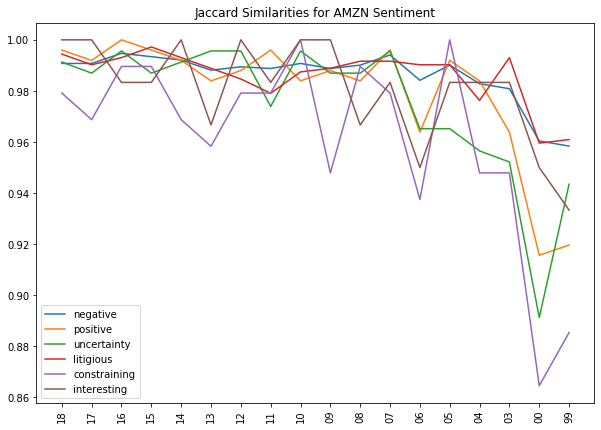

In [22]:
file_dates = {
    ticker: [ten_k['file_date'] for ten_k in ten_ks]
    for ticker, ten_ks in ten_ks_by_ticker.items()}

jaccard_similarities = {
    ticker: {
        sentiment_name: get_jaccard_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_bow_ten_ks.items()}
project_helper.plot_similarities(
    [jaccard_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Jaccard Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

### TFIDF
using the sentiment word lists, let's generate sentiment TFIDF from the 10-k documents. Implement `get_tfidf` to generate TFIDF from each document, using sentiment words as the terms. You can ignore words that are not in `sentiment_words`.

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer


def get_tfidf(sentiment_words, docs):
    """
    Generate TFIDF values from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    # filter out words not in sentiment_words
    vectorizer = TfidfVectorizer(vocabulary=sentiment_words.values)
    
    # build tfidf matrix
    tfidf = vectorizer.fit_transform(docs)
    
    return tfidf.toarray()

In [24]:
sentiment_tfidf_ten_ks = {}
for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]

    sentiment_tfidf_ten_ks[ticker] = {
        sentiment: get_tfidf(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs) for sentiment in sentiments
    }
project_helper.print_ten_k_data([sentiment_tfidf_ten_ks[example_ticker]], sentiments)

[
  {
    negative: '[[0.         0.         0.         ... 0.        ...
    positive: '[[0.24113923 0.         0.         ... 0.        ...
    uncertainty: '[[0.         0.         0.         ... 0.00504487...
    litigious: '[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0....
    constraining: '[[0.         0.         0.         ... 0.        ...
    interesting: '[[0.01878316 0.         0.         ... 0.        ...},
]


### Cosine Similarity
Using the TFIDF values, we'll calculate the cosine similarity and plot it over time. Implement `get_cosine_similarity` to return the cosine similarities between each tick in time. Since the input, `tfidf_matrix`, is a TFIDF vector for each time period in order, you just need to computer the cosine similarities for each neighboring vector.

tfidf函数求出的是按照时间顺序下sentiment_word_list的每个词的词频。
Cosine Similarity又反应了什么问题？

In [25]:
from sklearn.metrics.pairwise import cosine_similarity


def get_cosine_similarity(tfidf_matrix):
    """
    Get cosine similarities for each neighboring TFIDF vector/document

    Parameters
    ----------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    cosine_similarities : list of float
        Cosine similarities for neighboring documents
    """
    # compute cosine similarities between neighboring docs
    cosine_similarities = list(np.diag(cosine_similarity(tfidf_matrix, tfidf_matrix), k=1))
    
    return cosine_similarities


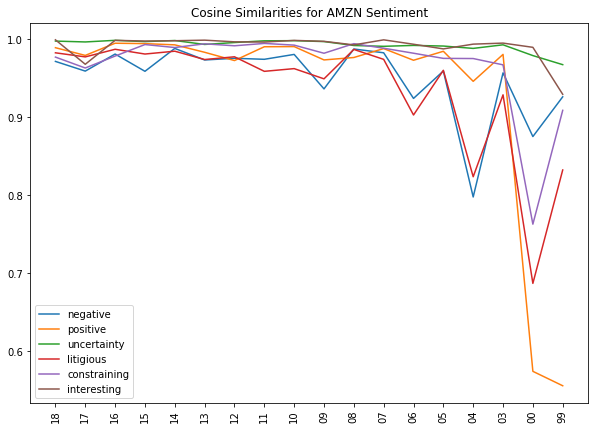

In [26]:
cosine_similarities = {}
for ticker, sentiment_tfidf_ten_k in sentiment_tfidf_ten_ks.items():
    cosine_similarities[ticker] = {
        sentiment: get_cosine_similarity(sentiment_tfidf_ten_k[sentiment]) for sentiment in sentiments
    }
project_helper.plot_similarities(
    [cosine_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Cosine Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

## Evaluate Alpha Factors
Just like we did in project 4, let's evaluate the alpha factors. For this section, we'll just be looking at the cosine similarities, but it can be applied to the jaccard similarities as well.
### Price Data
Let's get yearly pricing to run the factor against, since 10-Ks are produced annually.

这里有一个疑问：我这里仅仅使用一年的第一天的交易数据是否会有问题？

假设我们研究季报又应该怎么做呢？

如何将其变成每天都有数据呢？只需要将一季度一个的factor和每天都有的price做右连接，这样就得到了一个每天都有price和factor，当然绝大多数天数的factor是空的，这时使用dataframe.fillna(method = ‘ffill’)就行了，也就是向后填充，即在季报公布后，则使用这个数据直到下一份季报数据公布。


In [27]:
from sqlalchemy import create_engine
import datetime
import sqlite3

IFIL = os.path.join(os.path.join(os.path.dirname(os.getcwd()), 'project4-alpha_research_multi_factor_modeling', 'spy_history.db'))
sqlite_conn = sqlite3.connect(IFIL, check_same_thread=False)
engine = create_engine('sqlite:///'+IFIL, echo=True)


def get_pricing_data():
    all_data_df = pd.DataFrame()
    rng = pd.date_range('19941231', periods=25, freq='A')
    for pd_date in rng:
        add_one_day_date = last_day_datetime = pd_date.to_datetime()
        first_day_of_year = last_day_datetime + datetime.timedelta(days=1)

        tickers_df_sql_text = "SELECT `name` as ticker, `tran_date` as date, `adj_close` from main.stock_spy where tran_date=:date"
        one_data = pd.read_sql(sql=tickers_df_sql_text, con=engine, params={'date': last_day_datetime.strftime("%Y-%m-%d %H:%M:%S")})
        while one_data.shape[0] == 0:
            add_one_day_date = add_one_day_date + datetime.timedelta(days=1)
            one_data = pd.read_sql(sql=tickers_df_sql_text, con=engine,
                                   params={'date': add_one_day_date.strftime("%Y-%m-%d %H:%M:%S")})

        one_data['date'] = first_day_of_year
        tickers_df = one_data.pivot(index='date', columns='ticker', values='adj_close')
        # all_data_df = pd.concat([tickers_df, all_data_df], axis=0, join='inner')
        all_data_df = all_data_df.append(tickers_df)

    return all_data_df

In [28]:
pricing = get_pricing_data()

pricing.head()

2020-01-14 22:23:00,600 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-01-14 22:23:00,601 INFO sqlalchemy.engine.base.Engine ()
2020-01-14 22:23:00,603 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-01-14 22:23:00,605 INFO sqlalchemy.engine.base.Engine ()
2020-01-14 22:23:00,606 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("SELECT `name` as ticker, `tran_date` as date, `adj_close` from main.stock_spy where tran_date=:date")
2020-01-14 22:23:00,607 INFO sqlalchemy.engine.base.Engine ()
2020-01-14 22:23:00,609 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("SELECT `name` as ticker, `tran_date` as date, `adj_close` from main.stock_spy where tran_date=:date")
2020-01-14 22:23:00,610 INFO sqlalchemy.engine.base.Engine ()
2020-01-14 22:23:00,611 INFO sqlalchemy.engine.base.Engine SELECT `name` as ticker, `tran_date` as date, `adj_close` from main.stock_spy where t

2020-01-14 22:23:05,731 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("SELECT `name` as ticker, `tran_date` as date, `adj_close` from main.stock_spy where tran_date=:date")
2020-01-14 22:23:05,732 INFO sqlalchemy.engine.base.Engine ()
2020-01-14 22:23:05,734 INFO sqlalchemy.engine.base.Engine SELECT `name` as ticker, `tran_date` as date, `adj_close` from main.stock_spy where tran_date=:date
2020-01-14 22:23:05,735 INFO sqlalchemy.engine.base.Engine {'date': '1999-12-31 00:00:00'}
2020-01-14 22:23:06,230 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("SELECT `name` as ticker, `tran_date` as date, `adj_close` from main.stock_spy where tran_date=:date")
2020-01-14 22:23:06,231 INFO sqlalchemy.engine.base.Engine ()
2020-01-14 22:23:06,233 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("SELECT `name` as ticker, `tran_date` as date, `adj_close` from main.stock_spy where tran_date=:date")
2020-01-14 22:23:06,234 INFO sqlalchemy.engine.base.Engine ()
2020-01-1

2020-01-14 22:23:11,312 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("SELECT `name` as ticker, `tran_date` as date, `adj_close` from main.stock_spy where tran_date=:date")
2020-01-14 22:23:11,313 INFO sqlalchemy.engine.base.Engine ()
2020-01-14 22:23:11,315 INFO sqlalchemy.engine.base.Engine SELECT `name` as ticker, `tran_date` as date, `adj_close` from main.stock_spy where tran_date=:date
2020-01-14 22:23:11,316 INFO sqlalchemy.engine.base.Engine {'date': '2006-01-03 00:00:00'}
2020-01-14 22:23:11,825 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("SELECT `name` as ticker, `tran_date` as date, `adj_close` from main.stock_spy where tran_date=:date")
2020-01-14 22:23:11,827 INFO sqlalchemy.engine.base.Engine ()
2020-01-14 22:23:11,828 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("SELECT `name` as ticker, `tran_date` as date, `adj_close` from main.stock_spy where tran_date=:date")
2020-01-14 22:23:11,829 INFO sqlalchemy.engine.base.Engine ()
2020-01-1

2020-01-14 22:23:16,879 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("SELECT `name` as ticker, `tran_date` as date, `adj_close` from main.stock_spy where tran_date=:date")
2020-01-14 22:23:16,880 INFO sqlalchemy.engine.base.Engine ()
2020-01-14 22:23:16,881 INFO sqlalchemy.engine.base.Engine SELECT `name` as ticker, `tran_date` as date, `adj_close` from main.stock_spy where tran_date=:date
2020-01-14 22:23:16,882 INFO sqlalchemy.engine.base.Engine {'date': '2012-01-02 00:00:00'}
2020-01-14 22:23:17,390 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("SELECT `name` as ticker, `tran_date` as date, `adj_close` from main.stock_spy where tran_date=:date")
2020-01-14 22:23:17,391 INFO sqlalchemy.engine.base.Engine ()
2020-01-14 22:23:17,392 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("SELECT `name` as ticker, `tran_date` as date, `adj_close` from main.stock_spy where tran_date=:date")
2020-01-14 22:23:17,393 INFO sqlalchemy.engine.base.Engine ()
2020-01-1

2020-01-14 22:23:22,386 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("SELECT `name` as ticker, `tran_date` as date, `adj_close` from main.stock_spy where tran_date=:date")
2020-01-14 22:23:22,387 INFO sqlalchemy.engine.base.Engine ()
2020-01-14 22:23:22,388 INFO sqlalchemy.engine.base.Engine SELECT `name` as ticker, `tran_date` as date, `adj_close` from main.stock_spy where tran_date=:date
2020-01-14 22:23:22,389 INFO sqlalchemy.engine.base.Engine {'date': '2018-01-01 00:00:00'}
2020-01-14 22:23:22,887 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("SELECT `name` as ticker, `tran_date` as date, `adj_close` from main.stock_spy where tran_date=:date")
2020-01-14 22:23:22,888 INFO sqlalchemy.engine.base.Engine ()
2020-01-14 22:23:22,889 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("SELECT `name` as ticker, `tran_date` as date, `adj_close` from main.stock_spy where tran_date=:date")
2020-01-14 22:23:22,890 INFO sqlalchemy.engine.base.Engine ()
2020-01-1

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
1995-01-01,NaN,NaN,NaN,1.179026,NaN,NaN,4.131692,NaN,3.587569,3.815367,...,6.893270,3.367258,5.181523,4.315904,30.668676,NaN,NaN,NaN,6.246157,NaN
1996-01-01,NaN,NaN,NaN,0.998285,NaN,3.326054,5.385341,NaN,7.816436,5.894530,...,8.177417,5.656993,8.210989,5.555288,47.022457,NaN,NaN,NaN,14.008709,NaN
1997-01-01,NaN,NaN,NaN,0.648691,NaN,4.863093,6.687706,NaN,4.581388,8.713183,...,8.029989,6.611049,11.611075,6.890019,55.784039,NaN,NaN,NaN,18.683392,NaN
1998-01-01,NaN,NaN,NaN,0.407860,NaN,5.870989,8.825813,NaN,5.090262,9.495555,...,10.764842,6.296772,15.585035,8.912450,79.392456,NaN,3.444319,NaN,33.168976,NaN
1999-01-01,NaN,NaN,NaN,1.272134,NaN,6.551319,13.401249,NaN,5.789083,10.760197,...,10.783705,11.695607,19.541729,7.586113,128.242264,NaN,5.940522,NaN,46.087109,NaN


### Dict to DataFrame
The alphalens library uses dataframes, so we we'll need to turn our dictionary into a dataframe. 

In [34]:
cosine_similarities_df_dict = {'date': [], 'ticker': [], 'sentiment': [], 'value': []}
for ticker, ten_k_sentiments in cosine_similarities.items():
    for sentiment_name, sentiment_values in ten_k_sentiments.items():
        for sentiment_values, sentiment_value in enumerate(sentiment_values):
            cosine_similarities_df_dict['ticker'].append(ticker)
            cosine_similarities_df_dict['sentiment'].append(sentiment_name)
            cosine_similarities_df_dict['value'].append(sentiment_value)
            cut_out_date = file_dates[ticker][1:][sentiment_values]
            if int(cut_out_date) < 50:
                cut_out_date = datetime.datetime(2000 + int(cut_out_date), 1, 1)
            else:
                cut_out_date = datetime.datetime(1900 + int(cut_out_date), 1, 1)
            cosine_similarities_df_dict['date'].append(cut_out_date)

cosine_similarities_df = pd.DataFrame(cosine_similarities_df_dict)
cosine_similarities_df

,date,sentiment,ticker,value
0,2018-01-01,negative,AMZN,0.971864
1,2017-01-01,negative,AMZN,0.959419
2,2016-01-01,negative,AMZN,0.981316
3,2015-01-01,negative,AMZN,0.959162
4,2014-01-01,negative,AMZN,0.988547
5,2013-01-01,negative,AMZN,0.973707
6,2012-01-01,negative,AMZN,0.975888
7,2011-01-01,negative,AMZN,0.974569
8,2010-01-01,negative,AMZN,0.980850
9,2009-01-01,negative,AMZN,0.936573


### Alphalens Format
In order to use a lot of the alphalens functions, we need to aligned the indices and convert the time to unix timestamp. In this next cell, we'll do just that.

periods=1 代表的是未来一个周期的收益率，相当是一年的持有周期

In [35]:
import alphalens as al

factor_data = {}
skipped_sentiments = []
for sentiment in sentiments:
    cs_df = cosine_similarities_df[cosine_similarities_df['sentiment'] == sentiment]
    cs_df = cs_df.pivot(index='date', columns='ticker', values='value')

    try:
        clean_data = al.utils.get_clean_factor_and_forward_returns(factor=cs_df.stack(), prices=pricing, periods=[1], quantiles=5)
        factor_data[sentiment] = clean_data
    except:
        skipped_sentiments.append(sentiment)

if skipped_sentiments:
    print('\nSkipped the following sentiments:\n{}'.format('\n'.join(skipped_sentiments)))
    
factor_data

Dropped 10.4% entries from factor data: 10.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 10.4% entries from factor data: 10.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 10.4% entries from factor data: 10.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 10.4% entries from factor data: 10.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 10.4% entries from factor data: 10.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropp

{'negative':                         1D    factor  factor_quantile
 date       asset                                     
 1995-01-01 AAPL  -0.153297  0.890762                2
            AMD   -0.310000  0.561628                1
            BMY    0.515416  0.891432                3
            CVX    0.287827  0.909509                4
            HON    0.506002  0.939862                5
 1996-01-01 AAPL  -0.350195  0.968922                5
            BMY    0.370235  0.906993                4
            CVX    0.318637  0.716833                2
            FRT    0.263481  0.617979                1
            HON    0.403034  0.778497                3
 1997-01-01 AAPL  -0.371257  0.916349                5
            AMD   -0.310680  0.805317                2
            BMY    0.770725  0.905682                4
            FRT    0.012635  0.420647                1
 1998-01-01 BMY    0.429498  0.834929                5
            HON    0.159210  0.345556                

### Alphalens Format with Unix Time
Alphalen's `factor_rank_autocorrelation` and `mean_return_by_quantile` functions require unix timestamps to work, so we'll also create factor dataframes with unix time.

In [36]:
unixt_factor_data = {}
for sentiment, clean_factor_data in factor_data.items():
    unixt_factor_data[sentiment] = clean_factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in clean_factor_data.index.values],
        names=['date', 'asset']
    ))


### Factor Returns
Let's view the factor returns over time. We should be seeing it generally move up and to the right.


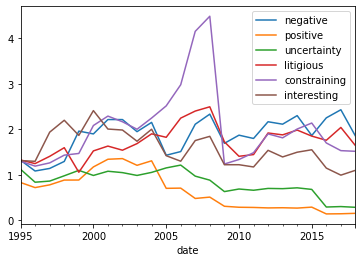

In [37]:
ls_factor_returns = pd.DataFrame()
for factor, clean_factor_data in factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(clean_factor_data).iloc[:, 0]

(1 + ls_factor_returns).cumprod().plot()

### Basis Points Per Day per Quantile
It is not enough to look just at the factor weighted return. A good alpha is also monotonic in quantiles. Let's looks the basis points for the factor returns.

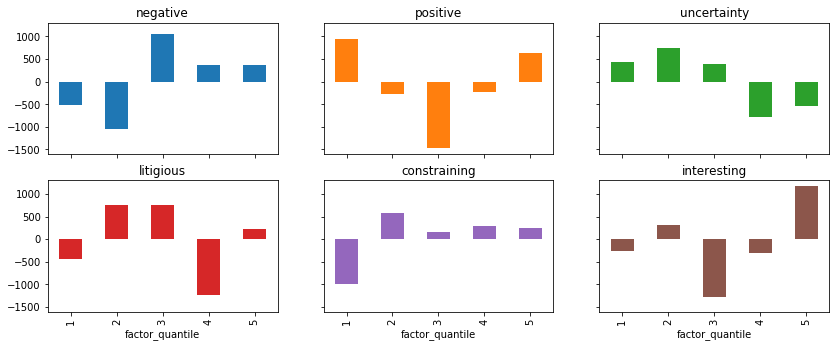

In [38]:
qr_factor_returns = pd.DataFrame()

for factor_name, data in unixt_factor_data.items():
    qr_factor_returns[factor_name] = al.performance.mean_return_by_quantile(data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(5,3),
    figsize=(14, 14),
    legend=False);

1. 分位数基本呈现出的是非单调，uncertainty 甚至变现结果与期望相反，基本表现都很差，需要做进一步研究和对alpha因子重新定义？怎么做？


### Turnover Analysis
Without doing a full and formal backtest, we can analyze how stable the alphas are over time. Stability in this sense means that from period to period, the alpha ranks do not change much. Since trading is costly, we always prefer, all other things being equal, that the ranks do not change significantly per period. We can measure this with the **Factor Rank Autocorrelation (FRA)**.

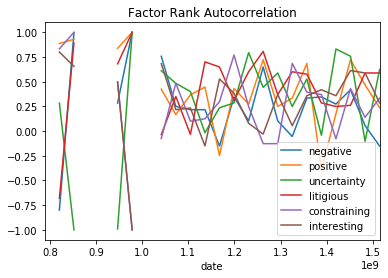

In [39]:
ls_FRA = pd.DataFrame()
for factor, clean_factor_data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(clean_factor_data)

ls_FRA.plot(title="Factor Rank Autocorrelation")

### Sharpe Ratio of the Alphas
The last analysis we'll do on the factors will be sharpe ratio. Let's see what the sharpe ratio for the factors are. Generally, a Sharpe Ratio of near 1.0 or higher is an acceptable single alpha for this universe.

百度百科是这么描述夏普比率的：

目的是计算投资组合每承受一单位总风险，会产生多少的超额报酬。比率依据资产配置线(Capital Allocation Line,CAL)的观念而来，是市场上最常见的衡量比率。当投资组合内的资产皆为风险性资产时，适用夏普比率。夏普指数代表投资人每多承担一分风险，可以拿到几分超额报酬；若为正值，代表基金报酬率高过波动风险；若为负值，代表基金操作风险大过于报酬率。这样一来，每个投资组合都可以计算Sharpe Ratio,即投资回报与多冒风险的比例，这个比例越高，投资组合越佳。

举例而言，假如国债的回报是3%，而您的投资组合预期回报是15%，您的投资组合的标准偏差是6%，那么用15%－3%,可以得出12%（代表您超出无风险投资的回报），再用12%/6%=2，代表投资者风险每增长1%，换来的是2%的多余收益。

In [40]:
def sharpe_ratio(factor_returns, annualization_factor):
    """
    Get the sharpe ratio for each factor for the entire period

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns for each factor and date
    annualization_factor: float
        Annualization Factor

    Returns
    -------
    sharpe_ratio : Pandas Series of floats
        Sharpe ratio
    """

    return annualization_factor * factor_returns.mean() / factor_returns.std()

In [43]:
sharpe_ratio_df = sharpe_ratio(qr_factor_returns, np.sqrt(252)).round(2)
sharpe_ratio_df

negative        0.91
positive       -1.30
uncertainty     1.20
litigious       0.23
constraining    1.50
interesting    -1.31
dtype: float64